In [ ]:
import numpy as np
import cv2 
from google.colab.patches import cv2_imshow

In [ ]:
img = cv2.imread('download.png', 1)

k_matrix = np.array([[698.86, 0, 306.91],
                          [0, 699.13, 150.34],
                          [0, 0, 1]])
k_inv = np.linalg.inv(k_matrix)

d = np.array([0.191887, -0.563680, -0.003676, -0.002037, 0])


h, w = img.shape[:2]

#K, roi = cv2.getOptimalNewCameraMatrix(k_matrix, d, (w, h), 0, (w, h))
img_undistort = cv2.undistort(img, k_matrix, d, None)#, K)

# crop image
#x, y, w, h = roi
#img_crop = img_undistort[y: y + h, x: x + w]

img2 = cv2.inRange(img_undistort, (140,140,140), (160, 160, 160))
img3 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)

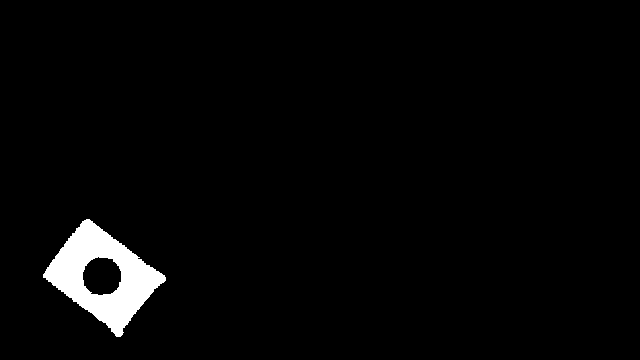

In [ ]:
cv2_imshow(img2)

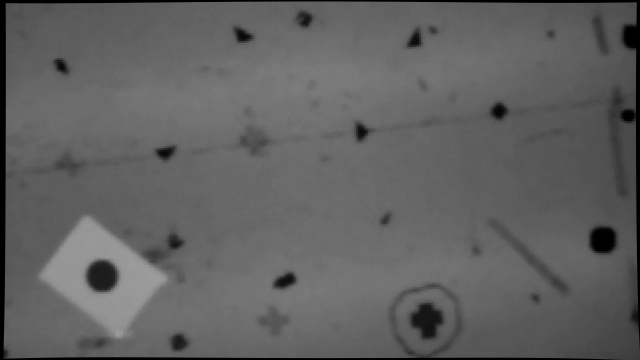

In [ ]:
cv2_imshow(img_undistort) 

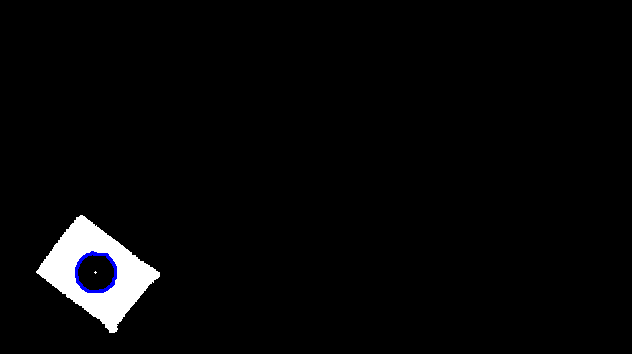

In [ ]:
contours, _= cv2.findContours(img2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour_list = []
center_list = []
for contour in contours:
    approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
    area = cv2.contourArea(contour)
    if ((len(approx) > 8) & (area > 30) ):
        contour_list.append(contour)
        M = cv2.moments(contour)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        center_list.append([cX, cY])

cv2.drawContours(img3, contour_list,  -1, (255,0,0), 2)
cv2.circle(img3, (cX, cY), 1, (255, 255, 255), -1)
cv2_imshow(img3)

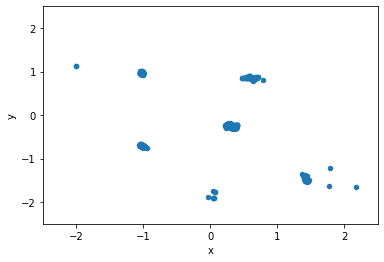

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df_1 = pd.read_csv('location.txt', sep=' ',header=None)
df_1.plot.scatter(0,1)
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Kmeans

In [2]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0).fit(df_1)
center_kmeans = kmeans.cluster_centers_
center_kmeans

array([[ 0.61039573,  0.85776811],
       [ 0.3201706 , -0.25711444],
       [-1.02981067,  0.97332893],
       [-1.01416367, -0.71356501],
       [ 1.45182397, -1.47496311],
       [ 0.04118713, -1.85313495]])

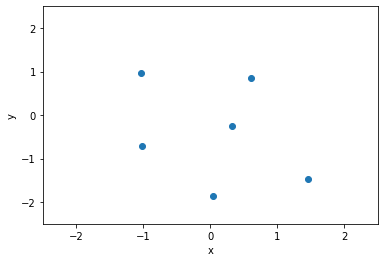

In [3]:

plt.scatter(center_kmeans[:,0],center_kmeans[:,1])
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# DBSCAN

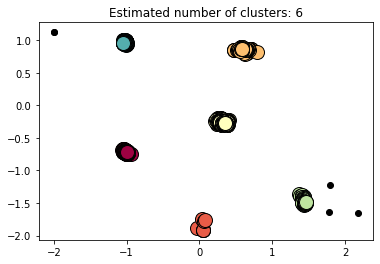

In [4]:
from sklearn.cluster import DBSCAN
import numpy as np

db = DBSCAN(eps=0.3,min_samples=5).fit(df_1)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    xy = np.array(df_1)[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
            markeredgecolor='k', markersize=14)

    xy = np.array(df_1)[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

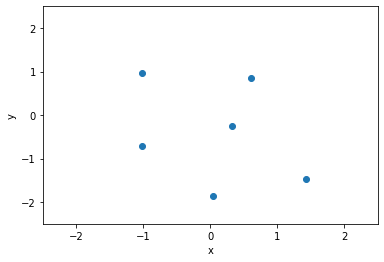

In [5]:
center_db = []
for i in range(n_clusters_):
  points_of_cluster_0 = np.array(df_1)[labels==i,:]
  
  centroid_of_cluster_0 = np.mean(points_of_cluster_0, axis=0) 
  center_db.append(centroid_of_cluster_0)

center_db = np.array(center_db)

plt.scatter(center_db[:,0],center_db[:,1])
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [6]:
center_db

array([[-1.01416367, -0.71356501],
       [ 0.04118713, -1.85313495],
       [ 0.61039573,  0.85776811],
       [ 0.3201706 , -0.25711444],
       [ 1.4310729 , -1.47349036],
       [-1.02413486,  0.97244425]])

# Cluster Class

In [7]:
class Cluster():
    def __init__(self):
        self.clusters = []
        self.threshold = 0.3
        self.minPts = 5
        return

    def cluster(self, locations):
        print("Start Clustering")
        for i in range(len(locations)):
            location = locations[i]
            found = False

            for j in range(len(self.clusters)):
                cluster = self.clusters[j]['cluster']
                center = self.clusters[j]['center']
                dist = self.calc_dist(location, center)
                if dist < self.threshold:
                    cluster.append(location)
                    center = self.calc_center(cluster)
                    self.clusters[j] = {'center': center, 'cluster': cluster}
                    found = True
                    break
            if not found:
                self.clusters.append({'center': location, 'cluster': [location]})

        final_clusters = self.find_cluster(self.clusters, self.minPts)
        print('\nFinal Estimation:')
        for i in range(len(final_clusters)):
            print (final_clusters[i]['center'])

        return final_clusters

    def calc_dist(self, p1, p2):
        x1, y1 = p1[0], p1[1]
        x2, y2 = p2[0], p2[1]
        return np.sqrt(abs(x1 - x2) ** 2 + abs(y1 - y2) ** 2)

    def calc_center(self, cluster):
        return np.mean(np.array(cluster), axis=0)

    def find_cluster(self, clusters, threshold):
        new_clusters = []
        for i in range(len(clusters)):
            cluster = clusters[i]['cluster']
            center = clusters[i]['center']
            if len(cluster) > threshold:
                new_clusters.append({'center': center, 'cluster': cluster})
        return new_clusters

In [9]:
locations = np.array(df_1)
final_cluster = Cluster().cluster(locations)

Start Clustering

Final Estimation:
[-1.01416367 -0.71356501]
[ 0.04118713 -1.85313495]
[0.61039573 0.85776811]
[ 0.3201706  -0.25711444]
[ 1.4310729  -1.47349036]
[-1.02413486  0.97244425]


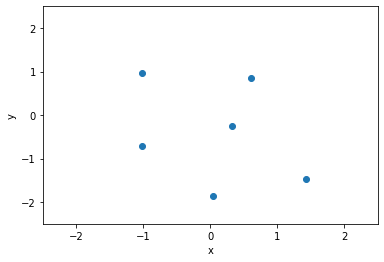

In [10]:
center_cls = np.array([final_cluster[i]['center'] for i in range(len(final_cluster))])
plt.scatter(center_cls[:,0],center_cls[:,1])
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

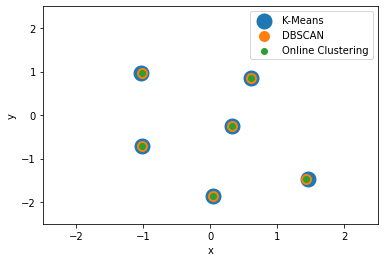

In [14]:
plt.scatter(center_kmeans[:,0],center_kmeans[:,1],linewidths=10,label='K-Means')
plt.scatter(center_db[:,0],center_db[:,1],linewidths=5,label='DBSCAN')
plt.scatter(center_cls[:,0],center_cls[:,1],linewidths=1,label='Online Clustering')

plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()